In [1]:
import torch
import torchvision.datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

from torchsummary import summary

import matplotlib.pyplot as plt

## Datasets

In [2]:
mnist_dataset = torchvision.datasets.MNIST(
    root="Mnist_dataset",
    download=True,
    train=True,
    transform=ToTensor()
)

In [3]:
train,val,test = torch.utils.data.random_split(mnist_dataset,(0.8,0.1,0.1))

In [4]:
batch_size = 500
train_loader = DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

In [5]:
val_loader = DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

## VAE Encoder
Similar to standard Autoencoder, but with two independent lineal layer to represent mean and logvar


In [6]:
def Conv_block(in_channels,out_channels, kernel_size = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Encoder(nn.Module):
    def __init__(self, in_channels:int , latent_dims:int):
        super().__init__()
        self.convolutions = nn.Sequential(
            Conv_block(in_channels,128),
            Conv_block(128,256),
            Conv_block(256,512),
            Conv_block(512,1024)
        )

        self.mu = nn.Linear(1024,latent_dims)
        self.logvar = nn.Linear(1024,latent_dims)

    def forward(self, x:torch.Tensor):
        bs = x.shape[0]
        # print(x.shape)

        x = self.convolutions(x)
        x = x.reshape(bs,-1)
        # x = x.flatten(start_dim=1)
        mu = self.mu(x)
        logvar = self.logvar(x)

        return mu,logvar
        # return x

In [ ]:
# VAE_encoder = Encoder(in_channels=1,latent_dims=2).cuda()

# # VAE_encoder(a.cuda()).shape

# summary(VAE_encoder, (1,28,28), batch_size=100)

## Decoder
Similar to standard decoder, but take a data from distribution defined by encoder.
Actually, we don't need to make non changes. 

In [7]:
def conv_transpose_block(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=0,
        with_act=True
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding
            )   
    ]

    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())

    return nn.Sequential(*modules)


class Decoder(nn.Module):
    def __init__(self,out_channels:int , latent_dims:int):
        super().__init__()

        self.lineal = nn.Linear(latent_dims,1024*4*4)
        self.t_conv = nn.Sequential(
            conv_transpose_block(1024,512),
            conv_transpose_block(512,256,output_padding=1),
            conv_transpose_block(256,out_channels,output_padding=1,with_act=False)
        )

    def forward(self, x:torch.Tensor):
        bs = x.shape[0]

        x = self.lineal(x)
        x = x.reshape((bs,1024,4,4))
        x = self.t_conv(x)
        
        return x

## Variational Autoencoder

In [8]:
class VAE_AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims:int):
        super().__init__()
        self.encoder = Encoder(in_channels,latent_dims)
        self.decoder = Decoder(in_channels,latent_dims)

    def encode(self,x):
        return self.encoder(x)

    def decode(self,z):
        return self.decoder(z)


    def forward(self,x):
        mu,logvar = self.encode(x)
        
        #Take a sample from distribution
        std = torch.exp(0.5*logvar) # Compute standard desviation
        z = self.sample(mu,std)
        
        reconstructed = self.decode(z)

        # Return reconstructed image and, mean and logvar to calculate losses
        return reconstructed, mu, logvar



    def sample(self,mu,std):
        standard_sample = torch.randn_like(std)

        return mu + (standard_sample * std) # Take a sample of standarized distribution and transforming it to mean and desviation given
                                            # This method is used to simplify gradient calculus

In [9]:
VAE_model = VAE_AutoEncoder(in_channels=1,latent_dims=2).cuda()
summary(VAE_model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                    [-1, 2]           2,050
           Linear-14                   

## Training VAE
We create a new loss from combitanion of two losses:
* The old one, from recreated images
* A new from logvar: *Kullback–Leibler divergence* (KLD) is a functions that compares a distribution from another one, in this case, the standard

This combination is a sum of boths

In some cases, we can put more weigth on one of the lossesx, to balance the reconstruction of gaussian distribution.


In [10]:
import torch.nn.functional as F
def vae_loss(batch, reconstructed_image, mu, logvar):
    bs = batch.shape[0]


    reconstruction_loss = F.mse_loss(
        reconstructed_image.reshape(bs, -1),
        batch.reshape(bs,-1),
        reduction="none"
    ).sum(dim=-1)

    KL_loss = -0.5* torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    loss = (reconstruction_loss + KL_loss).mean(dim=0)

    return (loss, reconstruction_loss, KL_loss)


In [11]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "KL_loss": []
    }

    train_losses = 0

    # losses_list = []

    for nlote,(x,_) in enumerate(loader):
        x = x.cuda()

        # Forward Pass
        reconstructed ,mu ,logvar = model(x)

        # Backpropagation
        loss,reconstruction_loss,KL_loss = loss_fn(x, reconstructed, mu, logvar)    #Calculo de loss
        
        loss.backward()             #Calculo de gradiente
        
        # Save Losses
        losses["loss"].append(
            loss.item())
        losses["reconstruction_loss"].append(
            reconstruction_loss.mean().item()
        )
        losses["KL_loss"].append(
            KL_loss.mean().item()
        )

        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print("Reconstruction_loss:\t",reconstruction_loss.mean().item())
            print("KL_loss:\t\t",KL_loss.mean().item())
            print()

    train_losses /= nlotes
    print()
    print("\tAccuracy/Loss Promedio")
    # print(f"\t\tEntrenamiento: {(100*train_accuracy):>0.1f}% / {train_losses:>8f}")
    print(f"\t\tEntrenamiento: {train_losses:>8f}")

    return losses

In [12]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Calcelo el calculo del gradiente
        for x,_ in loader:
            
            x = x.cuda()
            recosntructed, mu, logvar = model(x)       # Inferencia
            
            loss,_,_ = loss_fn(x, recosntructed, mu, logvar)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\t\t Validación: {val_losses:>8f}")

    return losses_list


In [13]:
epochs = 10
lr = 0.0001

optimizer = torch.optim.AdamW(VAE_model.parameters(),lr=lr,eps=1e-5)

In [14]:
training_losses = {
        "loss": [],
        "reconstruction_loss": [],
        "KL_loss": []
    }
val_losses = []


for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    output_output = train_loop(train_loader,VAE_model,optimizer,vae_loss)
    training_losses["loss"]                 += output_output["loss"]
    training_losses["reconstruction_loss"]  += output_output["reconstruction_loss"]
    training_losses["KL_loss"]              += output_output["KL_loss"]
    
    #Validation
    val_output = val_loop(train_loader,VAE_model,vae_loss)
    val_losses += val_output

print("Finalizado entrenamiento del modelo!")
# output_losses = train_loop(train_loader,VAE_model,optimizer,vae_loss)

Itenración: 1 / 10 -----------------------------
Nº de lote:	 0
Loss:			 6404.6513671875
Reconstruction_loss:	 6404.40625
KL_loss:		 0.2450684756040573

Nº de lote:	 10
Loss:			 501.65545654296875
Reconstruction_loss:	 487.124267578125
KL_loss:		 14.53114128112793

Nº de lote:	 20
Loss:			 177.7333526611328
Reconstruction_loss:	 156.08486938476562
KL_loss:		 21.648481369018555

Nº de lote:	 30
Loss:			 113.5593032836914
Reconstruction_loss:	 91.24446105957031
KL_loss:		 22.314842224121094

Nº de lote:	 40
Loss:			 88.55736541748047
Reconstruction_loss:	 69.02593231201172
KL_loss:		 19.531435012817383

Nº de lote:	 50
Loss:			 76.25074768066406
Reconstruction_loss:	 61.47785568237305
KL_loss:		 14.7728910446167

Nº de lote:	 60
Loss:			 71.30551147460938
Reconstruction_loss:	 59.46116256713867
KL_loss:		 11.844351768493652

Nº de lote:	 70
Loss:			 66.30562591552734
Reconstruction_loss:	 55.9569206237793
KL_loss:		 10.348701477050781

Nº de lote:	 80
Loss:			 63.841487884521484
Reconstr

In [ ]:
training_losses["reconstruction_loss"]

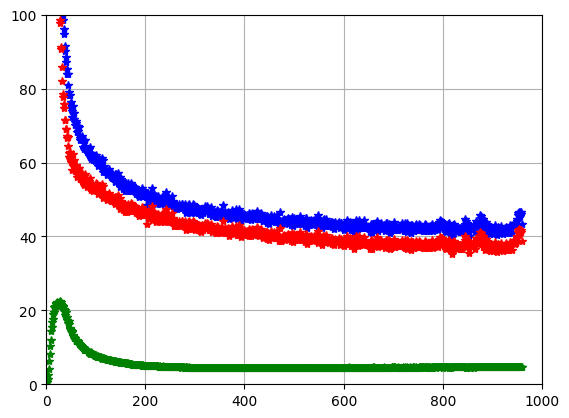

In [16]:
fig = plt.figure()
plt.plot(range(len(training_losses["loss"])),training_losses["loss"],"b*")
plt.plot(range(len(training_losses["reconstruction_loss"])),training_losses["reconstruction_loss"],"r*")
plt.plot(range(len(training_losses["KL_loss"])),training_losses["KL_loss"],"g*")
plt.axis((0,1000,0,100),)
plt.grid()

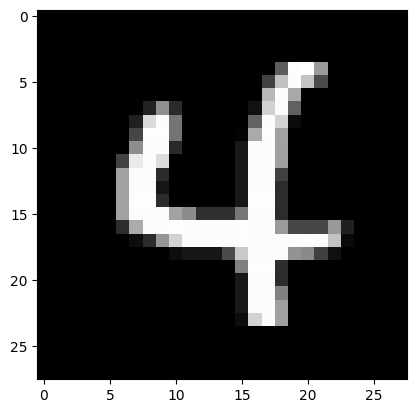

In [17]:
steps = len(train)

img = test[torch.randint(len(test),(1,))][0].unsqueeze(0).cuda()

VAE_model.eval()
with torch.inference_mode():
    reconstructed_img = VAE_model(img)[0]
plt.imshow(img.cpu().squeeze(),cmap="grey");

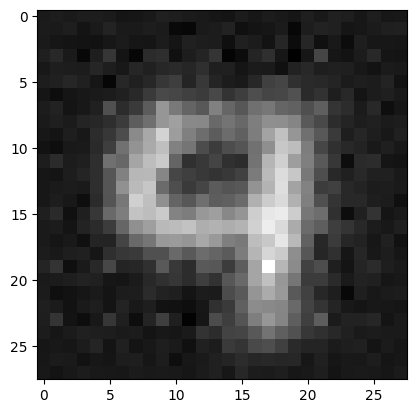

In [18]:
plt.imshow(reconstructed_img.cpu().detach().squeeze(),cmap="grey");

## Latent Space Representation
The latent space that the VAE create should be more structurated.
We expect that the representation of the numbers to follow an gaussian distribution on this space, making easy to generate new data from space points.

In [19]:
test_output = {
    0:[[],[]],
    1:[[],[]],
    2:[[],[]],
    3:[[],[]],
    4:[[],[]],
    5:[[],[]],
    6:[[],[]],
    7:[[],[]],
    8:[[],[]],
    9:[[],[]]
}

VAE_model.eval()
for img,lbl in test:

    # lbls_list.append(lbl)

    with torch.inference_mode():
        mu_output = VAE_model.encode(img.cuda().unsqueeze(1))[0]   #We only need the mu value
    
    test_output[lbl][0].append(mu_output[0].cpu().tolist()[0])
    test_output[lbl][1].append(mu_output[0].cpu().tolist()[1])

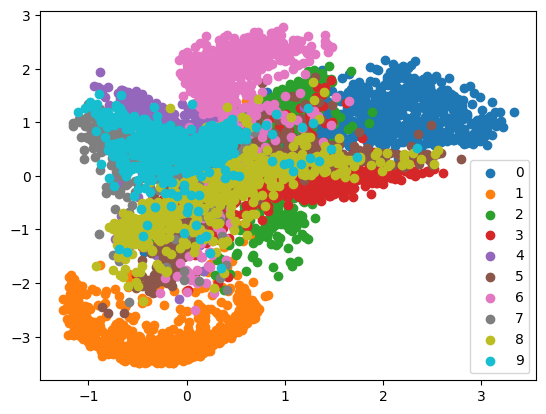

In [20]:
plt.Figure(figsize=(10,8))
for key in test_output.keys():
    plt.scatter(test_output[key][0],test_output[key][1],label=key);
plt.legend();

In [108]:
y = 0
x_range = torch.arange(-4,3.5,0.1)
z = torch.empty((len(x_range),2))
for idx,x in enumerate(x_range):
    z[-idx-1] = torch.tensor([y,x.item()])

new_data = VAE_model.decode(z.cuda())

In [109]:
img_list = []
for img in new_data:
    img_list.append(img.squeeze())
    # torch.cat((img_list,img.cpu()),dim=1)

img_array = torch.cat(img_list,dim=0)


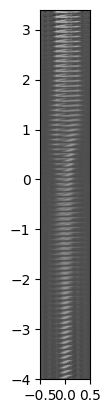

In [110]:
plt.imshow(img_array.cpu().detach(),cmap="grey",extent=[y-0.5, y+0.5,x_range[0], x_range[-1]]);


In [111]:
import numpy as np
def normalizar_a_255_general(array_numpy):
    """
    Normaliza un array de NumPy a escala de grises (rango [0, 255], dtype uint8)
    detectando automáticamente los valores mínimo y máximo del array de entrada.

    Args:
        array_numpy: El array de NumPy de entrada.

    Returns:
        Un array de NumPy normalizado en el rango [0, 255] y tipo de dato uint8.
        Si todos los valores de entrada son iguales, devuelve un array lleno de 127 (gris medio).
    """
    min_valor = np.min(array_numpy) # Encontrar el valor mínimo en el array
    max_valor = np.max(array_numpy) # Encontrar el valor máximo en el array

    # Caso especial: Si el valor mínimo y máximo son iguales, evitar división por cero y devolver un array gris medio
    if max_valor == min_valor:
        return np.full_like(array_numpy, 127, dtype=np.uint8) # Devolver array lleno de gris medio (valor 127)

    # Normalización general: Mapear el rango [min_valor, max_valor] a [0, 255]
    array_normalizado = (array_numpy - min_valor) / (max_valor - min_valor) * 255
    return array_normalizado.astype(np.uint8) # Convertir a uint8

In [112]:
for ind in range(len(img_list)):
    img_list[ind] = normalizar_a_255_general(img_list[ind].cpu().detach().numpy())

In [ ]:
import imageio
imageio.mimsave("Vector.gif",img_list,)